In [2]:
from cobra import Configuration
from cobra.io import read_sbml_model
import pandas as pd
import cobra
from sklearn.preprocessing import MinMaxScaler
from cobra.manipulation.delete import remove_genes, prune_unused_metabolites, prune_unused_reactions
import seaborn as sns
import matplotlib.pyplot as plt
from corda import CORDA

I am setting to the solver an open source linear programming alternative: "GLPK" to solve the stoichiometric matrix

In [3]:
config = Configuration()
config.solver = "glpk"
config

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,7
cache_directory,Path for the model cache,/Users/karthik/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


Here, parent model will be Recon3D, from which context specific models: Epithelial and Mesenchymal CSMs are created.

In [3]:
recon3d_model = read_sbml_model('/Users/karthik/Desktop/PHCCO IISc Internship/EMT/Recon3D.xml')
recon3d_model

Name,Recon3D
Memory address,17648b810
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


Then I read the EMT expression data for Mesenchymal and Epithelial each, to get the CSMs of based of each of the columns

In [4]:
expression_data = pd.read_csv(
   # "/Users/karthik/Desktop/PHCCO IISc Internship/emt_expression_data_with_recon_id.csv"
   "/Users/karthik/Desktop/PHCCO IISc Internship/EMT_FINAL_DATA.csv"
)
expression_data.head()

,Gene_ID,Mesenchymal,Epithelial
0,2978_AT1,1.590799,-7.624877
1,1571_AT1,6.046029,3.480441
2,1549_AT1,2.358338,3.101581
3,1548_AT1,2.358338,3.101581
4,949_AT1,8.881953,8.613039


The following cell was created to read the fasting expression data, which was assigned to the same variable as we read above.
This expression data is used on each of Epithelial and Mesenchymal CSMs, to create Epithelial-Fasting CSM and Mesenchymal-Fasting CSM.

In [4]:
expression_data = pd.read_csv('/Users/karthik/Desktop/PHCCO IISc Internship/EMT/processed_s11_expression_data.csv')
expression_data

,symbol,baseMean,log2fold_change,p_value,baseMean_normalized,-log10(p_value),regulation
0,DDX11L1,0.258591,0.036116,0.879453,-0.059476,0.055788,Not significant
1,WASH7P,12.983945,0.008918,0.970470,-0.056637,0.013018,Not significant
2,LOC729737,21.638194,0.006211,0.982015,-0.054706,0.007882,Not significant
3,FAM138D,0.114211,0.033687,0.800134,-0.059508,0.096837,Not significant
4,LOC101928626,0.250746,0.107664,0.588727,-0.059478,0.230086,Not significant
...,...,...,...,...,...,...,...
25535,BCORP1,0.075737,0.027772,0.834668,-0.059517,0.078486,Not significant
25536,TXLNGY,0.210122,-0.012409,0.940506,-0.059487,0.026638,Not significant
25537,KDM5D,0.294809,-0.022351,0.911426,-0.059468,0.040279,Not significant
25538,PRORY,0.054897,0.027772,0.834668,-0.059522,0.078486,Not significant


This algorithm creates a base model by removing all the unnecessary genes, reactions and dead-end metabolites from the parent model, recon3d. Then it returns the base model, from which all the context specific models are made.

In [5]:
# Extract the list of genes from the expression data
expression_genes = expression_data["Gene_ID"].tolist()

def filter_model_by_genes(model, genes):
    """
    Filter a COBRA model to include only reactions associated with a given list of genes (gene ids).
    """
    # Copy the model
    new_model = model.copy()

    # Get the list of genes in the model
    genes_in_model = [gene.id for gene in new_model.genes]

    # Find genes to remove
    genes_to_remove = list(set(genes_in_model) - set(genes))
    
    genes_to_remove_by_id = set()
    
    for gene in new_model.genes:
        if gene.name in genes_to_remove:
            genes_to_remove_by_id.add(gene.id)
            
    genes_to_remove_by_id = list(genes_to_remove_by_id)

    # Remove genes and their associated reactions
    remove_genes(new_model, genes_to_remove_by_id, remove_reactions=True)
    new_model, _ = prune_unused_reactions(new_model)
    new_model, _ = prune_unused_metabolites(new_model)

    return new_model

# Create the context-specific model
filtered_model = filter_model_by_genes(recon3d_model, expression_genes)

# Save or analyze the new model
cobra.io.write_sbml_model(filtered_model, "emt_base.xml")

In [6]:
model = filtered_model.copy()
model

Name,Recon3D
Memory address,106b8aed0
Number of metabolites,5835
Number of reactions,10597
Number of genes,2229
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [4]:
model = read_sbml_model('emt_base.xml')
model

Name,Recon3D
Memory address,322dfbad0
Number of metabolites,5835
Number of reactions,10597
Number of genes,2229
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


In [5]:
model = read_sbml_model('Mesenchymal_csm.xml')
model

Name,Recon3D
Memory address,17eca0310
Number of metabolites,1295
Number of reactions,1657
Number of genes,895
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, mitochondria, peroxisome/glyoxysome, extracellular space, lysosome, endoplasmic reticulum, nucleus, inner mitochondrial compartment"


The following cell does 
1. Normalizing gene expression using MinMaxScaler. 
2. Confidence Levels for Genes are assigned confidence levels based on their normalized expression values using thresholds calculated from statistical properties of the data.
3. Gene-Confidence Mapping: For each reaction, the associated genes' confidence levels are retrieved.
4. Propagating Confidence: The reaction is assigned the lowest confidence level among its associated genes. If no associated genes are found, a default confidence level of -1 is assigned.
   
Justification: Using the lowest confidence among associated genes ensures that reactions are not over-confidently included if any associated gene suggests a lower confidence.
Thresholds: Reflect realistic ranges for high, medium, and low expression, providing a balanced and scientifically meaningful distribution of confidence levels.

In [6]:
id_column_name = "symbol"
column_name = 'baseMean'

# Normalize the 'Sensitive' column
scaler = MinMaxScaler()
expression_data[f'Normalized_{column_name}'] = scaler.fit_transform(expression_data[[column_name]])

# Calculate statistics for confidence level thresholds
mean = expression_data[f'Normalized_{column_name}'].mean()
std_dev = expression_data[f'Normalized_{column_name}'].std()

# highest_confidence_threshold = mean + std_dev

highest_confidence_threshold = expression_data[f'Normalized_{column_name}'].quantile(0.90)
lowest_confidence_threshold = mean - std_dev

percentile_25 = expression_data[f'Normalized_{column_name}'].quantile(0.25)
percentile_50 = expression_data[f'Normalized_{column_name}'].quantile(0.50)
percentile_75 = expression_data[f'Normalized_{column_name}'].quantile(0.75)

# Assign confidence levels to genes
def assign_gene_confidence(value):
    if value >= highest_confidence_threshold:
        return 3
    elif value >= percentile_75:
        return 2
    elif value >= percentile_50:
        return 1
    elif value >= percentile_25:
        return 0
    elif value <= lowest_confidence_threshold:
        return -1
    else:
        return 0

expression_data['Gene_Confidence_Level'] = expression_data[f'Normalized_{column_name}'].apply(assign_gene_confidence)

# Initialize a dictionary to store reaction confidence levels
reaction_confidence = {}

# Assign confidence levels to reactions based on associated genes
for reaction in model.reactions:
    reaction_id = reaction.id
    associated_genes = [gene.name for gene in reaction.genes]
    
    # Get the confidence levels of the associated genes
    gene_confidences = expression_data.loc[expression_data[id_column_name].isin(associated_genes), 'Gene_Confidence_Level']

    # Propagate the lowest confidence level to the reaction
    if not gene_confidences.empty:
        reaction_confidence[reaction_id] = gene_confidences.min()
    else:
        reaction_confidence[reaction_id] = -1  # Assign -1 if no associated genes found
        
# Assign highest confidence level to specific biomass reactions
for biomass_reaction_id in ['BIOMASS_maintenance_noTrTr', 'BIOMASS_maintenance', 'BIOMASS_reaction']:
    if biomass_reaction_id in reaction_confidence:
        reaction_confidence[biomass_reaction_id] = 3

# Convert the dictionary to a DataFrame
reaction_confidence_df = pd.DataFrame(list(reaction_confidence.items()), columns=['Reaction_ID', 'Confidence_Level'])

# Save the result to a CSV file
reaction_confidence_df.to_csv(f"reaction_{column_name}_confidence_levels.csv", index=False)

# Print to check
print(reaction_confidence_df)

             Reaction_ID  Confidence_Level
0     EX_5adtststerone_e                -1
1             EX_5fthf_e                -1
2             EX_5mthf_e                -1
3               2AMADPTm                 0
4              2OXOADPTm                 0
...                  ...               ...
1652            HMR_0795                 0
1653            HMR_2817                 2
1654            HMR_2821                 2
1655            HMR_2857                 2
1656            HMR_4772                 1

[1657 rows x 2 columns]


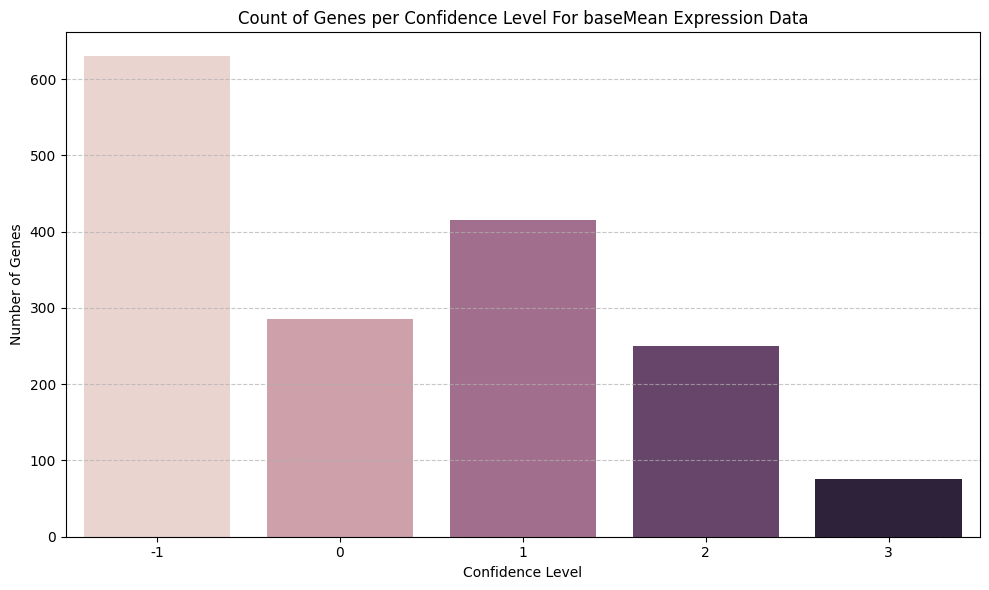

In [7]:
# Plot Count of Genes per Confidence Level
plt.figure(figsize=(10, 6))
sns.countplot(data=reaction_confidence_df, x='Confidence_Level', hue='Confidence_Level', legend=False)
plt.xlabel('Confidence Level')
plt.ylabel('Number of Genes')
plt.title(f'Count of Genes per Confidence Level For {column_name} Expression Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Confidence levels are converted to dict to match the argument type for CORDA reconstruction.

In [8]:
# Convert to dictionary
reaction_confidence_dict = reaction_confidence_df.set_index('Reaction_ID')['Confidence_Level'].to_dict()

# Display the dictionary
print(reaction_confidence_dict)

{'EX_5adtststerone_e': -1, 'EX_5fthf_e': -1, 'EX_5mthf_e': -1, '2AMADPTm': 0, '2OXOADPTm': 0, '34DHPHEt': 0, '4HBZCOAFm': -1, '4HBZFm': -1, '4MOPt2im': -1, '5ADTSTSTERONEGLCtr': -1, '5ADTSTSTERONEte': -1, '5FTHFt2_1': 1, 'A4GALTc': 1, 'AACTtm': -1, 'ABTArm': 2, 'ABUTt2rL': 2, 'ACACT10m': 1, 'ACETONEt2': 1, 'ACGAMK': 2, 'ACGAMPM': 2, 'ACGAMtly': -1, 'ACNML': -1, 'ACOAO7p': 3, 'ACONTm': 2, 'ADEt': 1, 'ADK3': 1, 'ADK3m': 2, 'ADSL2r': 1, 'AGTim': 0, 'AHANDROSTANGLCte': 2, 'AIRCr': 3, 'AKGMALtm': 1, 'ALASm': 0, 'ALCD22_D': 0, 'ALCD2y': 2, 'ALR2': 1, 'AMETt2m': 1, 'AMPDA': 0, 'ANDRSTRNGLCte': 2, 'ANDRSTRNGLCtr': -1, 'ANDRSTRNtr': -1, 'ASNNm': 0, 'ASNS1': 1, 'ASPGLUm': 1, 'ASPTAm': 2, 'BILGLCURte': 2, 'ATPasel_1': 0, 'C160CPT1': 0, 'C160CPT2': 1, 'C161CPT12': 0, 'C180CPT1': 0, 'C226COAtx': -1, 'C226CPT1': 0, 'C226CPT2': 1, 'C3STDH1r': 1, 'C4STMO1r': 2, 'CATm': 2, 'CATp': 2, 'CDIPTr': 2, 'CHLP': 0, 'CHOLK': 0, 'CITRtm': 0, 'CITtam': 1, 'CO2tm': -1, 'COAtim': 2, 'COQ3m': 0, 'COQ6m': 1, 'COQ7m':

Now, I recontruct the models. The `build` method in CORDA uses confidence scores to modify the emt base model, retaining high-confidence reactions and possibly excluding or down-weighting low-confidence reactions. The goal is to produce a smaller, more accurate model that reflects the specific biological context.

In [9]:
opt = CORDA(model, reaction_confidence_dict)
opt.build()
print(opt)

build status: reconstruction complete
Inc. reactions: 762/1657
 - unclear: 138/286
 - exclude: 247/630
 - low and medium: 301/665
 - high: 76/76



Output being stored in `opt`, I use the model from the variable, to get `new_model` which could be any Context specific model, based on column which is picked, ie.., epithelial or mesenchymal CSM in my case.

In [10]:
new_model = opt.cobra_model(column_name)
new_model

Name,Recon3D
Memory address,30144e390
Number of metabolites,641
Number of reactions,762
Number of genes,597
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, mitochondria, peroxisome/glyoxysome, extracellular space, lysosome, endoplasmic reticulum, nucleus, inner mitochondrial compartment"


Stored the model following the standard `SBML` format as `.xml`

In [12]:
cobra.io.write_sbml_model(new_model, f"mesenchymal_fasting_integrated_csm.xml")